# Posture detection using tensorflow判斷人體姿態<br>Step 4

Previously, we used the MoveNet model from tensorflow_hub to recognize the pose of an image and plotted the output of MoveNet pose keypoints on the image using matplotlib. <br>
In this task, we will also use the MoveNet model from tensorflow-hub to achieve human pose recognition. <br>
However, we will no longer use static images, but instead use the opencv library to read image data from the camera or video files. <br>
Finally, we will create a squat counter based on the output of MoveNet!<br>
<br>
之前，我們通過tensorflow_hub的MoveNet模型識別了一張圖片的姿態，並將MoveNet姿態關鍵點的輸出用matplotlib繪製在了圖片之上。<br>
在這個任務中，我們同樣會直接使用tensorflow-hub現有的MoveNet模型達成人體姿態識別的目標。<br>
不過，我們不再使用靜態圖片，而是利用opencv庫，從攝像頭或影片讀取圖像數據。<br>
最後，我們還會根據MoveNet的輸出，製作一個深蹲計數器！<br>

##### Import the necessary libraries and initialize codes we defined in the step 3. <br>先導入所需的庫，並初始化step 3中我們定義的函數。<br>

In [7]:
print("====== Importing from step 3 ... ======")

# ===import the libraries===
import tensorflow as tf
import tensorflow_hub as hub 
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

import cv2 

print("Libraries imported.")



# ===load the MoveNet pre-trained model from tensorflow-hub using the hub.load() function===
model_name = "movenet_lightning"
if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
else:
    raise ValueError("Unsupported model name: %s" % model_name)

print("Model loaded.")
    


# ===Download an image for pose detection (if no "input_image.jpeg" file in directory)===
import os 
# Download the demo image, if doesn't exist in current folder
if "input_image.jpeg" not in os.listdir():
    os.system('curl -o input_image.jpeg https://images.pexels.com/photos/4384679/pexels-photo-4384679.jpeg --silent')
input_path = "input_image.jpeg"

print("Image loaded.")



# === Define Function: movenet ===
# === Define KEYPOINT_DICT with key: keypoints of body, value: its index in MoveNet output ===
def movenet(input_image):
    #input image tensor, output np.array of normalized result
    
    model = module.signatures["serving_default"]
    input_image_casted = tf.cast(input_image, dtype=tf.int32)
    output = model(input_image_casted) ["output_0"].numpy()
    return output

KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}



# ===Define dict KEYPOINT_EDGE_INDS_TO_COLOR===
# ===Define _keypoints_and_edges_for_display===
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
    """Returns high confidence keypoints and edges for visualization.

    Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.
    
    Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the absolute coordinates of all keypoints of all detected entities;
      * the absolute coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
    """
    keypoints_all = []
    keypoint_edges_all = []
    edge_colors = []
    _, num_instances, _, _ = keypoints_with_scores.shape
    
    for idx in range(num_instances):
        kpts_x = keypoints_with_scores[0, idx, :, 1]        # x coordinate, normalized
        kpts_y = keypoints_with_scores[0, idx, :, 0]        # y coordinate, normalized
        kpts_scores = keypoints_with_scores[0, idx, : , 2]  # score
        kpts_absolute_xy = np.stack((width*kpts_x, height*kpts_y), axis=1)
        kpts_above_thresh_absolute_xy = kpts_absolute_xy[
            kpts_scores > keypoint_threshold, :]
        keypoints_all.append(kpts_above_thresh_absolute_xy)

        for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
            kpt_idx1 , kpt_idx2 = edge_pair[0], edge_pair[1]
            if (kpts_scores[kpt_idx1] > keypoint_threshold and
               kpts_scores[kpt_idx2] > keypoint_threshold):
                x_start, y_start = kpts_absolute_xy[kpt_idx1]
                x_end, y_end = kpts_absolute_xy[kpt_idx2]
                line_seg = np.array([[x_start, y_start], [x_end, y_end]])
                keypoint_edges_all.append(line_seg)
                edge_colors.append(color)
    if keypoints_all:
        keypoints_xy = np.concatenate(keypoints_all)
    else:
        keypoints_xy = np.zeros((0, 17, 2))
    
    if keypoint_edges_all:
        edges_xy = np.stack(keypoint_edges_all, axis=0)
    else:
        edges_xy = np.zeros((0, 2, 2))
    return keypoints_xy, edges_xy, edge_colors


                                         
# ===Define: draw_prediction_on_image===
# changes: we will need to show too many pictures,
#      so matplotlib is configured to "Agg" mode, and forced GC is used
from matplotlib.collections import LineCollection
from matplotlib import patches

import gc

def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):

    """Draws the keypoint predictions on image.

    Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.
    with_padding: if the result keeps edge padding. Normally if the input image
      to the MoveNet has padding but in display won't padding, with_padding = 0
    
    Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
    """
        
    matplotlib.use("Agg")     # important, memery leak will orrur if without this statement
    
    height, width, channel = image.shape
    aspect_ratio = width / height

    fig, ax = plt.subplots( figsize=( 4*aspect_ratio, 4 ) )
    fig.tight_layout(pad = 0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis("off")

    ax.imshow(image)
    line_segments = LineCollection([], linewidths=(4), linestyle = 'solid' )
    ax.add_collection(line_segments)

    scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

    keypoint_locs, keypoint_edges, edge_colors = ( _keypoints_and_edges_for_display(
        keypoints_with_scores, height, width) )
        
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
    scat.set_offsets(keypoint_locs)

    if crop_region is not None:
        xmin = max(crop_region['x_min'] * width, 0.0)
        ymin = max(crop_region['y_min'] * height, 0.0)
        rec_width = min(crop_region['x_max'], 0.99) * width - xmin
        rec_height = min(crop_region['y_max'], 0.99) * height - ymin
        rect = patches.Rectangle(
            (xmin,ymin),rec_width,rec_height,
            linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close("all")
    plt.clf()
    gc.collect()     # important, memery leak will orrur if without this statement
    return image_from_plot


        
# ===Defined IPython widget: stopButton===
from IPython.display import display, Image
import IPython
import ipywidgets as widgets
import threading

stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


print('''
The following functions have been imported:
   movenet(input_image)
   _keypoints_and_edges_for_display(keypoints_with_scores, height, width, keypoint_threshold=0.11)
   draw_prediction_on_image(image, keypoints_with_scores, crop_region=None, close_figure=False, output_image_height=None)
The following global variables have been assigned:
   module, model_name, input_size, KEYPOINT_DICT, KEYPOINT_EDGE_INDS_TO_COLOR
=======================================
'''
)

if __name__ != "__main__":
    print("====== Importing from step 4 ... ======")


====== Importing from step 3 ... ======
Libraries imported.
Model loaded.
Image loaded.

The following functions have been imported:
   movenet(input_image)
   _keypoints_and_edges_for_display(keypoints_with_scores, height, width, keypoint_threshold=0.11)
   draw_prediction_on_image(image, keypoints_with_scores, crop_region=None, close_figure=False, output_image_height=None)
The following global variables have been assigned:
   module, model_name, input_size, KEYPOINT_DICT, KEYPOINT_EDGE_INDS_TO_COLOR



## 1. Function Encapsulation  函數封裝

##### 
The MoveNet model requires an input array of size [1, 192, 192, 3], but our existing images have variable sizes. Therefore, we first need to convert the existing images to TensorFlow format and then adjust the image size to the required size of the model.<br>
MoveNet模型要求的輸入是大小為[1, 192, 192, 3]的數組，但是我們現有的圖像是大小可變的frame<br>
所以我們首先要將現有的圖片轉換成tensorflow格式，再調整圖片到模型要求的大小。<br>
<br>
Function`load_image_to_tf` loads the image into TensorFlow and converts it to TensorFlow format.<br>
`load_image_to_tf`函數將圖像加載到TensorFlow中，並將其轉換為TensorFlow格式。<br>

In [8]:
def load_image_to_tf(image):
    # convert image to tf format
    # input argument "image" can be Array of image, or a string of the path to an image in jpeg format
    if isinstance(image, str):
        image = tf.io.read_file(image)
        image_converted = tf.io.decode_jpeg(image)
    else: 
        image_converted = tf.convert_to_tensor(image)
    return image_converted


if __name__ == "__main__":
    image_converted = load_image_to_tf(input_path)
    print(type(image_converted), image_converted.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'> (3989, 3268, 3)


##### Function `tf_image_to_model` converts TensorFlow-format image to model-required format. It extends the dimensions of input tensor and uses function `resize_with_pad` to adjust it to the specified width and height.<br>`tf_image_to_model`函數：將`load_image_to_tf`輸出的TensorFlow格式的圖像轉換為模型所需的格式。我們需要先擴展輸入的張量的維度，並使用`resize_with_pad`函數將其調整為指定的width和height大小。<br>

In [9]:
def tf_image_to_model(image, width, height):
    # convert to model required format
    image_expand_dim = tf.expand_dims(image, 0)
    input_image = tf.image.resize_with_pad(image_expand_dim, width, height)
    return input_image


if __name__ == "__main__":
    input_image = tf_image_to_model(image_converted, input_size, input_size)
    print(type(input_image), input_image.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'> (1, 192, 192, 3)


##### Function `show_image` is for displaying images. It draws the image with Matplotlib and displays it on the GUI.<br> `show_image`函數用於顯示圖像。它使用Matplotlib庫將圖像繪製出來，並將其顯示在圖形界面上。


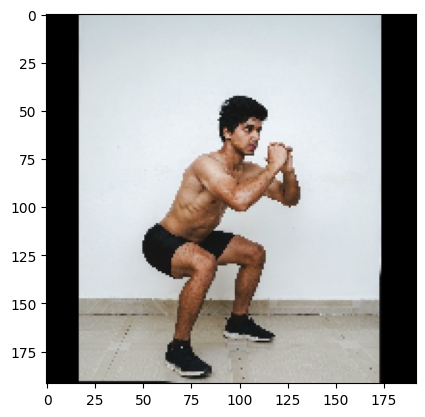

In [10]:
def show_image(image):
    # show an image using matplotlib. 
    # matplotlib is changed to "Agg" mode in the end to disable interaction to avoid memory leak
    matplotlib.use('module://ipykernel.pylab.backend_inline')
    plt.clf()
    if isinstance(image, np.ndarray):
        plt.imshow(image / 255)
    else:
        plt.imshow(image.numpy() / 255.0)
    plt.show()
    matplotlib.use('Agg')


if __name__ == "__main__":
    show_image(input_image[0])

##### <hr>
Encapsulate the process of inputting an image into the MoveNet pose detection using the previously defined functions, into a function  `get_keypoints_with_scores_from_image_with_movenet(...)`:<br>使用前面定義的函數，將圖像輸入到MoveNet姿勢判別的這一过程，封裝成`get_keypoints_with_scores_from_image_with_movenet(...)`函數：



In [11]:
def get_keypoints_with_scores_from_image_with_movenet(image, width, height):
    """
    Return the keypoints with scores from a given image using Movenet

    Args:
    image: can be Array of image, or a string of the path to the image
    width: width of input image Model required
    height: height of input image Model required

    Return: 
    A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    """
    image_converted = load_image_to_tf(image)
    input_image = tf_image_to_model(image_converted, width, height)
    keypoints_with_scores = movenet(input_image)
    return keypoints_with_scores

if __name__=="__main__":
    print(get_keypoints_with_scores_from_image_with_movenet(input_path, input_size, input_size))

[[[[0.33078307 0.57207555 0.36926246]
   [0.31447476 0.57787424 0.635139  ]
   [0.3123616  0.552008   0.5708574 ]
   [0.3197211  0.55927014 0.2833013 ]
   [0.31868088 0.49974856 0.55858785]
   [0.4119817  0.54748225 0.44850639]
   [0.41022906 0.43935308 0.63575625]
   [0.5048667  0.65530074 0.46787718]
   [0.50849646 0.52826107 0.6649901 ]
   [0.42503965 0.640712   0.5084336 ]
   [0.4205613  0.61755955 0.5540139 ]
   [0.6047405  0.41460285 0.58825314]
   [0.60769254 0.3206834  0.71418047]
   [0.6492917  0.56412005 0.50114304]
   [0.6847605  0.42757225 0.67536616]
   [0.8359229  0.51886916 0.36800522]
   [0.8992364  0.3546763  0.5767884 ]]]]


In [12]:

if __name__ != "__main__":
    print('''
The following functions have been imported:
   load_image_to_tf(image)
   tf_image_to_model(image, width, height)
   get_keypoints_with_scores_from_image_with_movenet(image, width, height)
   show_image(image)
=======================================
    '''
    )